In [37]:
import deepxde as dde
import numpy as np

In [38]:
a = dde.Variable(1.0)
b = dde.Variable(1.0)
c = dde.Variable(1.0)

In [39]:
geom = dde.geometry.TimeDomain(0, 5)

In [40]:
def Lorenz_system(t, w):
    x, y, z = w[:, 0:1], w[:, 1:2], w[:, 2:]
    dx_t = dde.grad.jacobian(w, t, i=0)
    dy_t = dde.grad.jacobian(w, t, i=1)
    dz_t = dde.grad.jacobian(w, t, i=2)
    return [
        dx_t - a * (y - x),
        dy_t - x * (b - z) - y, 
        dz_t - x * y - c * z,
    ]

In [41]:
ic1 = dde.icbc.IC(geom, lambda X: 7, lambda _, on_initial: on_initial, component=0)
ic2 = dde.icbc.IC(geom, lambda X: 15, lambda _, on_initial: on_initial, component=1)
ic3 = dde.icbc.IC(geom, lambda X: 15, lambda _, on_initial: on_initial, component=2)

In [42]:
def gen_traindata():
    data = np.load("/home/Alejandro/Gitlab/pinns/Lorenz_EQSyst/data.npz")
    return data["t"], data["w"]

In [43]:
observe_t, ob_w = gen_traindata()
observe_t = observe_t[0:-1:10]
ob_w = ob_w[0:-1:10]
observe_x = dde.icbc.PointSetBC(observe_t, ob_w[:, 0:1], component=0)
observe_y = dde.icbc.PointSetBC(observe_t, ob_w[:, 1:2], component=1)
observe_z = dde.icbc.PointSetBC(observe_t, ob_w[:, 2:3], component=2)

In [44]:
data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_x, observe_y, observe_z],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

/home/Alejandro/.local/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  warnings.warn("The balance properties of Sobol' points require "


In [45]:
net = dde.nn.FNN([1] + [50] * 3 + [3], "swish", "Glorot uniform")

In [46]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[a, b, c])
model.train(epochs=30000, callbacks=[variable])
model.compile("L-BFGS", external_trainable_variables=[a, b, c])

variable = dde.callbacks.VariableValue(
  [a, b, c], period=600, filename="variables.dat"
)

Compiling model...
Building feed-forward neural network...
'build' took 0.084166 s



/home/Alejandro/.local/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/Alejandro/.local/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.929316 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [9.97e-02, 9.22e-03, 1.58e-03, 4.90e+01, 2.25e+02, 2.25e+02, 3.04e+01, 3.87e+01, 1.70e+02]    [9.97e-02, 9.22e-03, 1.58e-03, 4.90e+01, 2.25e+02, 2.25e+02, 3.04e+01, 3.87e+01, 1.70e+02]    []  
1000      [9.87e+00, 7.33e-01, 1.11e+01, 6.20e+00, 1.48e+00, 1.27e+00, 2.59e+01, 1.10e+01, 3.17e+01]    [9.87e+00, 7.33e-01, 1.11e+01, 6.20e+00, 1.48e+00, 1.27e+00, 2.59e+01, 1.10e+01, 3.17e+01]    []  
2000      [9.67e+00, 5.65e-01, 3.09e+00, 6.13e+00, 2.76e-01, 3.51e-01, 2.43e+01, 1.09e+01, 3.03e+01]    [9.67e+00, 5.65e-01, 3.09e+00, 6.13e+00, 2.76e-01, 3.51e-01, 2.43e+01, 1.09e+01, 3.03e+01]    []  
3000      [1.02e+01, 8.75e-01, 2.36e+00, 5.94e+00, 1.58e-01, 1.99e-01, 2.30e+01, 1.12e+01, 2.92e+01]    [1.02

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
30000     [1.12e+00, 1.56e+00, 1.25e+00, 9.76e-04, 4.79e-04, 1.59e-03, 2.91e+00, 1.35e+00, 2.42e+00]    [1.12e+00, 1.56e+00, 1.25e+00, 9.76e-04, 4.79e-04, 1.59e-03, 2.91e+00, 1.35e+00, 2.42e+00]    []  
31000     [6.73e-01, 1.70e+00, 1.15e+00, 2.66e-03, 3.69e-03, 1.64e-04, 9.01e-01, 5.83e-01, 1.97e+00]                                                                                                      
32000     [3.63e-01, 1.72e+00, 1.14e+00, 2.19e-04, 3.01e-02, 1.13e-05, 1.63e-01, 1.74e-01, 1.41e+00]                                                                                                      
33000     [2.94e-01, 1.16e+00, 6.32e-01, 2.33e-03, 3.91e-04, 9.55e-04, 3.65e-01, 2.87e-01, 4.85e-01]                                                              

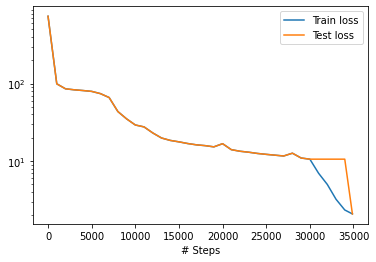

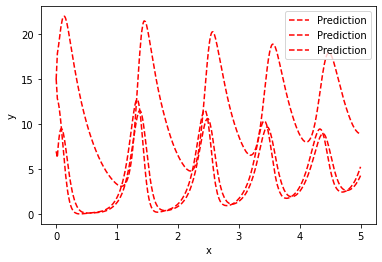

In [47]:
losshistory, train_state = model.train(callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

<function matplotlib.pyplot.show(close=None, block=None)>

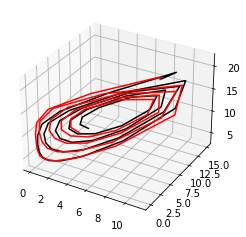

In [48]:
import matplotlib.pyplot as plt

Y = model.predict(observe_t)

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection="3d")
ax.plot(ob_w[:,0],ob_w[:,1],ob_w[:,2],"k")
ax.plot(Y[:,0],Y[:,1],Y[:,2],"r-")

plt.show
